<a href="https://colab.research.google.com/github/MalayathiGeetha/Deep_Learning_Practice_Notes/blob/main/Is%20it%20Bird%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [6]:
!pip install -Uqq duckduckgo_search

In [9]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

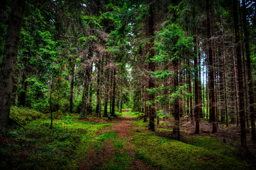

In [10]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [15]:
from fastai.vision.all import *
from fastai.vision.utils import download_images, resize_images, verify_images
from duckduckgo_search import DDGS
from pathlib import Path
from time import sleep
from random import randint


In [16]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'...")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

def safe_download(term, dest, max_images=30):
    try:
        urls = search_images(term, max_images)
        download_images(dest, urls=urls)
    except Exception as e:
        print(f"❌ Skipping '{term}' due to: {e}")
    sleep(randint(25, 40))  # Random delay


In [17]:
path = Path('bird_or_not')
searches = ['bird', 'forest']

for label in searches:
    dest = (path/label)
    dest.mkdir(parents=True, exist_ok=True)

    safe_download(f'{label} photo', dest)
    safe_download(f'{label} sun photo', dest)
    safe_download(f'{label} shade photo', dest)

    # Optional: Remove unsupported formats (like .fpx, .avif)
    exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
    for img in get_image_files(dest):
        if img.suffix.lower() not in exts:
            print(f"Removing unsupported: {img.name}")
            img.unlink()

    # Resize and clean images
    resize_images(dest, max_size=400)
    failed = verify_images(get_image_files(dest))
    failed.map(Path.unlink)
    print(f"✅ {label}: Downloaded and cleaned. Bad files removed: {len(failed)}")


Searching for 'bird photo'...
Searching for 'bird sun photo'...
Searching for 'bird shade photo'...
Removing unsupported: b8cca032-2964-4ce2-a851-2f159402485d.fpx
Removing unsupported: 906c193f-9bc5-41e3-aae0-3bfea0e5ad29.fpx
Removing unsupported: b723d720-4bc6-42bb-8bd9-cd00961874cd.fpx


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


✅ bird: Downloaded and cleaned. Bad files removed: 104
Searching for 'forest photo'...
Searching for 'forest sun photo'...
Searching for 'forest shade photo'...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


✅ forest: Downloaded and cleaned. Bad files removed: 52


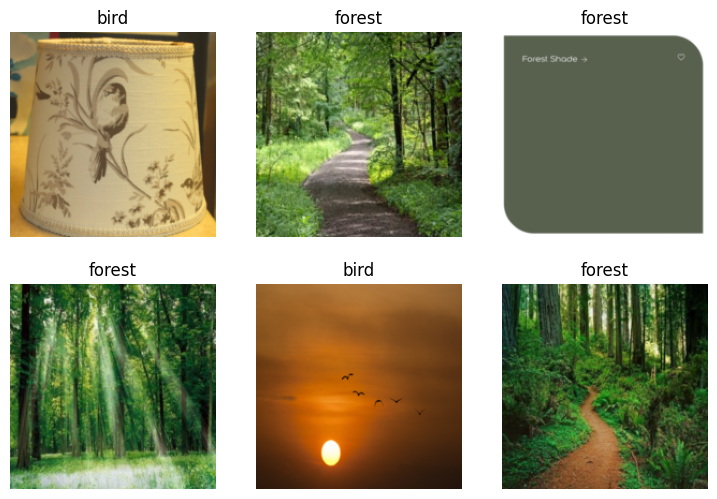

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}\nProbability it's a forest image: {probs[1]:.4f}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.329235,0.050444,0.018571,07:57


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.084061,0.020525,0.007143,10:51
1,0.038972,0.004462,0.001429,10:29
2,0.019534,0.002923,0.000000,10:28


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


This is a: bird.
Probability it's a bird: 1.0000
Probability it's a forest image: 0.0000
